In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import joblib
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import Parallel, delayed



In [ ]:
# Load the data
file_path = '/content/Car_Dena_93 h 955 - ir 44_Data_07_18_2024, 15_09_00_to_09_18_2024, 15_09_00.xlsx'
xls = pd.ExcelFile(file_path)
data_sheet = pd.read_excel(xls, sheet_name='Data')


In [ ]:
# Sort the data by 'trip' and 'Time' to maintain chronological order
data_sheet = data_sheet.sort_values(by=['trip', 'Time']).reset_index(drop=True)

# Reset 'Time' to start at 0 for each trip
data_sheet['Time'] = data_sheet.groupby('trip')['Time'].transform(lambda x: x - x.min())

# Verify that 'Time' starts at 0 for each trip
assert (data_sheet.groupby('trip')['Time'].first() == 0).all(), "Time did not reset to 0 for some trips."




In [ ]:
# Identify trips where 'Time' does not start at 0
invalid_trips = data_sheet[data_sheet['Time'] < 0]['trip'].unique()
if len(invalid_trips) > 0:
    print(f"Trips with invalid Time reset: {invalid_trips}")
    # Optionally, remove these trips
    data_sheet = data_sheet[~data_sheet['trip'].isin(invalid_trips)]


In [ ]:
# Filter out trips with fewer than 500 observations
filtered_trips = data_sheet.groupby('trip').filter(lambda x: len(x) > 500)

# Extract unique trips
unique_trips = filtered_trips['trip'].unique()


In [ ]:
# Define temperature bins and labels based on your data's temperature range
temp_bins = [0, 25, 35, 45, 55, 65, 75, 85, 95, 105]  # Adjust as needed
temp_labels = [f'{temp_bins[i]}-{temp_bins[i+1]}C' for i in range(len(temp_bins)-1)]


In [ ]:
# Function to assign a group based on initial coolant temperature
def assign_group(trip_data):
    initial_temp = trip_data['Coolant_temperature'].iloc[0]
    group = pd.cut([initial_temp], bins=temp_bins, labels=temp_labels, include_lowest=True)[0]
    if pd.isna(group):
        return 'Other'
    return group

# Create a DataFrame mapping each trip to its group
trip_groups = pd.DataFrame({
    'trip': unique_trips,
    'group': [
        assign_group(filtered_trips[filtered_trips['trip'] == trip])
        for trip in unique_trips
    ]
})


In [ ]:
# Create directories to save group-specific models
os.makedirs('models/groups', exist_ok=True)


In [ ]:
def fit_group_model(group, group_trips):
    group_data_series = [
        filtered_trips[filtered_trips['trip'] == trip]['Coolant_temperature']
        for trip in group_trips
    ]

    arima_params = []
    for trip_data in group_data_series:
        model = auto_arima(
            trip_data,
            start_p=1, start_q=1,
            max_p=3, max_q=3,
            seasonal=False,
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )
        arima_params.append(model.get_params())

    # Calculate average ARIMA order (p, d, q)
    avg_p = int(np.round(np.mean([param['order'][0] for param in arima_params])))
    avg_d = int(np.round(np.mean([param['order'][1] for param in arima_params])))
    avg_q = int(np.round(np.mean([param['order'][2] for param in arima_params])))
    avg_order = (avg_p, avg_d, avg_q)

    # Fit a representative ARIMA model for the group using the average order on a representative trip
    representative_trip = group_data_series[0]
    group_model = auto_arima(
        representative_trip,
        start_p=avg_order[0], start_q=avg_order[2],
        max_p=avg_order[0]+1, max_q=avg_order[2]+1,
        seasonal=False,
        trace=False,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )

    return (group, group_model)
# Fit group-specific models in parallel
results = Parallel(n_jobs=-1)(
    delayed(fit_group_model)(group, trip_groups[trip_groups['group'] == group]['trip'])
    for group in trip_groups['group'].unique()
)

# Save fitted models
group_models = {}
for group, model in results:
    group_models[group] = model
    model_filename = f'models/groups/group_{group}.pkl'
    joblib.dump(model, model_filename)
    print(f"Fitted ARIMA model for group '{group}' with order {model.order}.")


Fitted ARIMA model for group '55-65C' with order (2, 2, 2).
Fitted ARIMA model for group '75-85C' with order (0, 1, 1).
Fitted ARIMA model for group '85-95C' with order (1, 1, 2).
Fitted ARIMA model for group '65-75C' with order (3, 1, 0).
Fitted ARIMA model for group '35-45C' with order (4, 2, 0).
Fitted ARIMA model for group '25-35C' with order (4, 2, 0).
Fitted ARIMA model for group 'Other' with order (4, 1, 4).
Fitted ARIMA model for group '45-55C' with order (3, 2, 2).
Fitted ARIMA model for group '95-105C' with order (0, 2, 2).
Fitted ARIMA model for group '0-25C' with order (4, 2, 0).


In [ ]:
# Example: Forecasting for the last trip in the dataset
last_trip = unique_trips[-1]
new_trip_data = filtered_trips[filtered_trips['trip'] == last_trip].copy()

# Ensure 'Time' resets to 0 for the new trip
new_trip_data['Time'] = new_trip_data['Time'] - new_trip_data['Time'].min()

# Verify 'Time' reset
assert new_trip_data['Time'].iloc[0] == 0, "Time did not reset to 0 for the new trip."

# Determine the similarity group of the new trip
new_trip_initial_temp = new_trip_data['Coolant_temperature'].iloc[0]
new_trip_group = pd.cut([new_trip_initial_temp], bins=temp_bins, labels=temp_labels, include_lowest=True)[0]
if pd.isna(new_trip_group):
    new_trip_group = 'Other'

print(f"New trip '{last_trip}' assigned to group '{new_trip_group}' based on initial temperature {new_trip_initial_temp}°C.")


New trip '148' assigned to group '35-45C' based on initial temperature 45°C.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Predictions: 6548    557.600495
6549    557.882222
6550    558.163949
6551    558.445677
6552    558.727404
6553    559.009131
6554    559.290858
6555    559.572585
6556    559.854312
6557    560.136039
dtype: float64 ...
Last 10 Predictions Series: 6548    557.600495
6549    557.882222
6550    558.163949
6551    558.445677
6552    558.727404
6553    559.009131
6554    559.290858
6555    559.572585
6556    559.854312
6557    560.136039
dtype: float64
Length of Predictions: 1676
Forecasting Metrics for Trip '148': RMSE=277.87, MAE=246.71, MAPE=304.50%


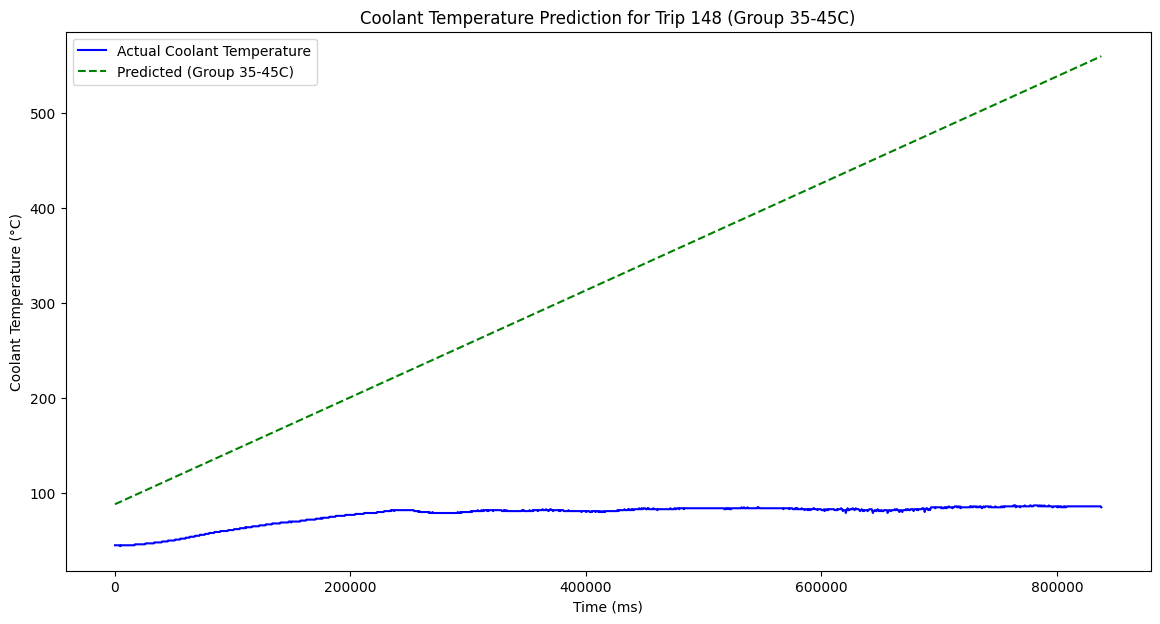

In [ ]:
# Check if the group-specific model exists
if new_trip_group in group_models:
    group_model = group_models[new_trip_group]

    # Forecast for the length of the new trip
    forecast_length = len(new_trip_data)
    predictions = group_model.predict(n_periods=forecast_length)
    print("Predictions:", predictions[-10:], "...")  # Print first 10 predictions for brevity

    # Create a Series for predictions without setting 'Time' as the index
    predictions_series = pd.Series(predictions)
    print("Last 10 Predictions Series:", predictions_series[-10:])

    # Calculate performance metrics (if actual data is available)
    # Here, since it's the same trip, we can compute metrics between predicted and actual
    actual = new_trip_data['Coolant_temperature'].values
    predicted = predictions_series.values
    print("Length of Predictions:", len(predicted))

    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    print(f"Forecasting Metrics for Trip '{last_trip}': RMSE={rmse:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}%")

    # Plot the actual vs predicted values for the last trip
    plt.figure(figsize=(14, 7))

    # Plot actual values
    plt.plot(new_trip_data['Time'], new_trip_data['Coolant_temperature'], label='Actual Coolant Temperature', color='blue')

    # Plot predictions from the group-specific model against 'Time'
    plt.plot(new_trip_data['Time'], predictions_series, label=f'Predicted (Group {new_trip_group})', linestyle='--', color='green')

    plt.title(f'Coolant Temperature Prediction for Trip {last_trip} (Group {new_trip_group})')
    plt.xlabel('Time (ms)')
    plt.ylabel('Coolant Temperature (°C)')
    plt.legend()
    plt.show()

else:
    print(f"No group-specific model found for group '{new_trip_group}'. Using a default strategy.")
    # Optional: Implement a default model or handle accordingly
